### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [ ]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [2]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [49]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'data/training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [6]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [103]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
# 印出網路結構
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         7

In [104]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [105]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

Epoch 1/150
27/27 [==============================] - ETA: 0s - loss: 0.0066
Epoch 00001: val_loss improved from inf to 0.00231, saving model to best_weights.h5
27/27 [==============================] - 6s 241ms/step - loss: 0.0066 - val_loss: 0.0023
Epoch 2/150
27/27 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00002: val_loss improved from 0.00231 to 0.00203, saving model to best_weights.h5
27/27 [==============================] - 6s 234ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 3/150
27/27 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00003: val_loss improved from 0.00203 to 0.00187, saving model to best_weights.h5
27/27 [==============================] - 6s 234ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 4/150
27/27 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00004: val_loss improved from 0.00187 to 0.00180, saving model to best_weights.h5
27/27 [==============================] - 6s 230ms/step - loss: 0.0012 - val_loss:

KeyboardInterrupt: 

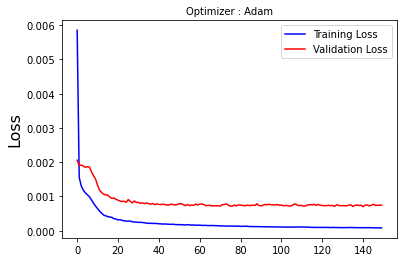

In [11]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [12]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'data/test.csv')

In [13]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

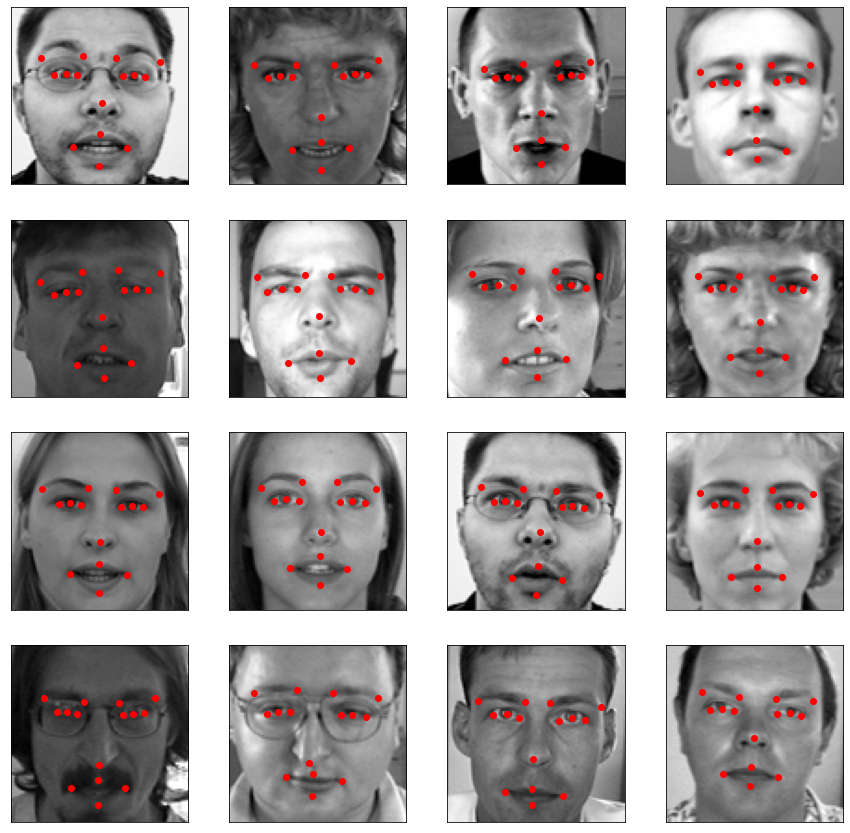

In [14]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [144]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [145]:
# Your code
checkpoint_augment = ModelCheckpoint('best_weights_augment.h5', verbose=1, save_best_only=True)
hist_augment = History()

In [116]:
points_train_flip = copy.deepcopy(points_train)
points_train_flip[:, ::2] = points_train_flip[:, ::2] * -1.0
points_train_concate = np.concatenate((points_train, points_train_flip))
imgs_train_flip = copy.deepcopy(imgs_train)
imgs_train_flip = imgs_train[:,:,::-1]
imgs_train_concate = np.concatenate((imgs_train, imgs_train_flip))

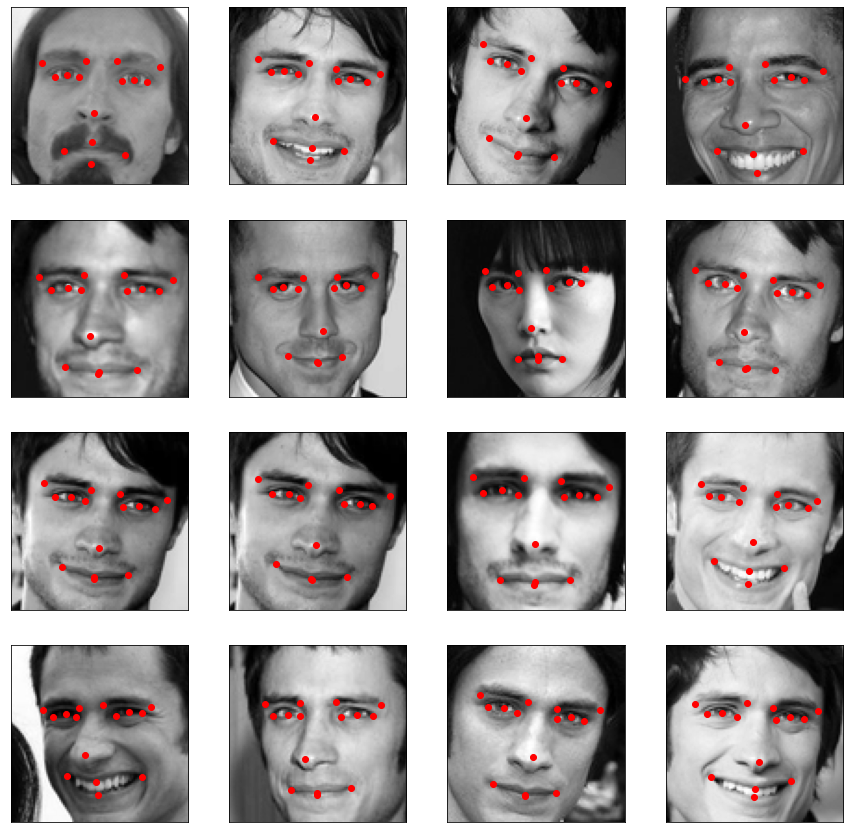

In [131]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
# points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
#     plot_keypoints(imgs_train_concate[i], np.squeeze(points_train_concate[i]))
#     ax = fig.add_subplot(4, 4, i + 9, xticks=[], yticks=[])
    plot_keypoints(imgs_train_concate[-i], np.squeeze(points_train_concate[-i]))

In [146]:
ind = list(range(points_train.shape[0]*2))
np.random.shuffle(ind)

# training the model
hist_model_augment = model_with_augment.fit(imgs_train_concate.reshape(-1, 96, 96, 1)[ind], 
                           points_train_concate[ind], 
                           validation_split=0.2, batch_size=64, callbacks=[checkpoint_augment, hist_augment],
                           shuffle=True, epochs=150, verbose=1)
# save the model weights
model_with_augment.save_weights('weights_augment.h5')
# save the model
model_with_augment.save('model_with_augment.h5')

Epoch 1/150
54/54 [==============================] - ETA: 0s - loss: 0.0206
Epoch 00001: val_loss improved from inf to 0.01873, saving model to best_weights_augment.h5
54/54 [==============================] - 13s 237ms/step - loss: 0.0206 - val_loss: 0.0187
Epoch 2/150
54/54 [==============================] - ETA: 0s - loss: 0.0189
Epoch 00002: val_loss improved from 0.01873 to 0.01810, saving model to best_weights_augment.h5
54/54 [==============================] - 12s 230ms/step - loss: 0.0189 - val_loss: 0.0181
Epoch 3/150
54/54 [==============================] - ETA: 0s - loss: 0.0159
Epoch 00003: val_loss improved from 0.01810 to 0.01348, saving model to best_weights_augment.h5
54/54 [==============================] - 12s 230ms/step - loss: 0.0159 - val_loss: 0.0135
Epoch 4/150
54/54 [==============================] - ETA: 0s - loss: 0.0122
Epoch 00004: val_loss improved from 0.01348 to 0.01050, saving model to best_weights_augment.h5
54/54 [==============================] - 12s 2

Epoch 36/150
54/54 [==============================] - ETA: 0s - loss: 4.6778e-04
Epoch 00036: val_loss did not improve from 0.00757
54/54 [==============================] - 13s 237ms/step - loss: 4.6778e-04 - val_loss: 0.0078
Epoch 37/150
54/54 [==============================] - ETA: 0s - loss: 4.7317e-04
Epoch 00037: val_loss did not improve from 0.00757
54/54 [==============================] - 12s 231ms/step - loss: 4.7317e-04 - val_loss: 0.0077
Epoch 38/150
54/54 [==============================] - ETA: 0s - loss: 4.5721e-04
Epoch 00038: val_loss did not improve from 0.00757
54/54 [==============================] - 13s 232ms/step - loss: 4.5721e-04 - val_loss: 0.0078
Epoch 39/150
54/54 [==============================] - ETA: 0s - loss: 4.4796e-04
Epoch 00039: val_loss did not improve from 0.00757
54/54 [==============================] - 13s 233ms/step - loss: 4.4796e-04 - val_loss: 0.0078
Epoch 40/150
54/54 [==============================] - ETA: 0s - loss: 4.4397e-04
Epoch 00040: va

Epoch 72/150
54/54 [==============================] - ETA: 0s - loss: 3.8964e-04
Epoch 00072: val_loss did not improve from 0.00722
54/54 [==============================] - 13s 242ms/step - loss: 3.8964e-04 - val_loss: 0.0073
Epoch 73/150
54/54 [==============================] - ETA: 0s - loss: 3.6265e-04
Epoch 00073: val_loss did not improve from 0.00722
54/54 [==============================] - 13s 246ms/step - loss: 3.6265e-04 - val_loss: 0.0072
Epoch 74/150
54/54 [==============================] - ETA: 0s - loss: 3.6739e-04
Epoch 00074: val_loss did not improve from 0.00722
54/54 [==============================] - 13s 235ms/step - loss: 3.6739e-04 - val_loss: 0.0075
Epoch 75/150
54/54 [==============================] - ETA: 0s - loss: 3.5856e-04
Epoch 00075: val_loss did not improve from 0.00722
54/54 [==============================] - 13s 233ms/step - loss: 3.5856e-04 - val_loss: 0.0074
Epoch 76/150
54/54 [==============================] - ETA: 0s - loss: 3.4592e-04
Epoch 00076: va

Epoch 108/150
54/54 [==============================] - ETA: 0s - loss: 2.8364e-04
Epoch 00108: val_loss did not improve from 0.00713
54/54 [==============================] - 13s 235ms/step - loss: 2.8364e-04 - val_loss: 0.0073
Epoch 109/150
54/54 [==============================] - ETA: 0s - loss: 2.8345e-04
Epoch 00109: val_loss did not improve from 0.00713
54/54 [==============================] - 12s 229ms/step - loss: 2.8345e-04 - val_loss: 0.0074
Epoch 110/150
54/54 [==============================] - ETA: 0s - loss: 2.7983e-04
Epoch 00110: val_loss did not improve from 0.00713
54/54 [==============================] - 13s 237ms/step - loss: 2.7983e-04 - val_loss: 0.0074
Epoch 111/150
54/54 [==============================] - ETA: 0s - loss: 2.7501e-04
Epoch 00111: val_loss did not improve from 0.00713
54/54 [==============================] - 13s 234ms/step - loss: 2.7501e-04 - val_loss: 0.0073
Epoch 112/150
54/54 [==============================] - ETA: 0s - loss: 2.7864e-04
Epoch 0011

54/54 [==============================] - ETA: 0s - loss: 2.9763e-04
Epoch 00143: val_loss did not improve from 0.00679
54/54 [==============================] - 12s 218ms/step - loss: 2.9763e-04 - val_loss: 0.0069
Epoch 144/150
54/54 [==============================] - ETA: 0s - loss: 2.9553e-04
Epoch 00144: val_loss did not improve from 0.00679
54/54 [==============================] - 12s 219ms/step - loss: 2.9553e-04 - val_loss: 0.0070
Epoch 145/150
54/54 [==============================] - ETA: 0s - loss: 2.8508e-04
Epoch 00145: val_loss did not improve from 0.00679
54/54 [==============================] - 12s 218ms/step - loss: 2.8508e-04 - val_loss: 0.0068
Epoch 146/150
54/54 [==============================] - ETA: 0s - loss: 2.8631e-04
Epoch 00146: val_loss did not improve from 0.00679
54/54 [==============================] - 12s 220ms/step - loss: 2.8631e-04 - val_loss: 0.0069
Epoch 147/150
54/54 [==============================] - ETA: 0s - loss: 2.8831e-04
Epoch 00147: val_loss di

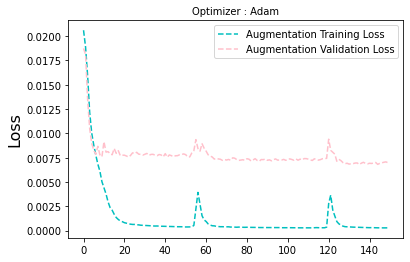

In [147]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
# plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
# plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.plot(hist_model_augment.history['loss'], '--', color='c', label='Augmentation Training Loss')
plt.plot(hist_model_augment.history['val_loss'], '--', color='pink', label='Augmentation Validation Loss')
plt.legend(loc='upper right')

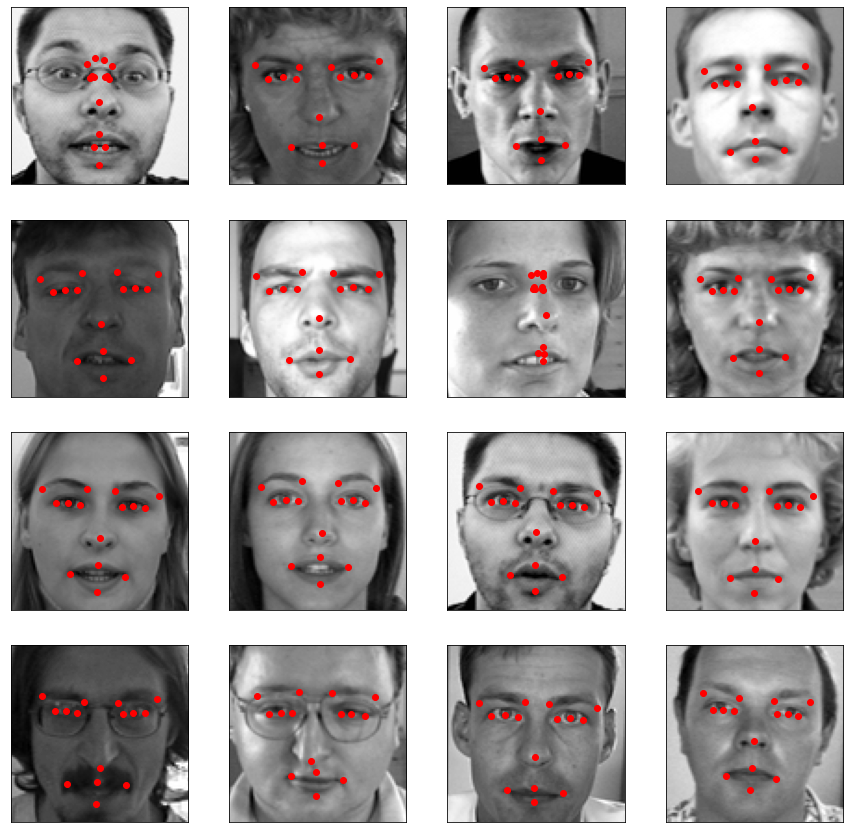

In [151]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test_augment = model_with_augment.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test_augment[i]))